### 2D-KPCA+LE算法框架
* 第一步：输入原始图像矩阵空间：n 副人脸图像矩阵$A_i\in R^{m*n}(i = 1,2,...,n )$； 
* 第二步：根据式（2.10）进行二维主成分分析得到投影矩阵（2.11）； 
* 第三步：根据高斯核函数式（4.9）进行核主成分分析特征提取； 
* 第四步：根据式（4.11）对特征集样本Y 构造权值矩阵； 
* 第五步：根据式（4.14）计算拉普拉斯矩阵 L ； 
* 第六步：根据式（4.16）对拉普拉斯矩阵进行特征值分解，并且进行低维投影。

### 生成瑞士卷数据集(验证LE算法)

In [117]:
def make_swiss_roll(n_samples=100, noise=0.0, random_state=None):
    # 生成瑞士卷数据集
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 83 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)
    return X, t

### 读取ORL人脸数据库数据集

In [118]:
from PIL import Image
import numpy as np
import os

img_data = []
content_path = 'data/'
for file in os.listdir(content_path):
    # 拼接完整文件路径
    cmp_path = os.path.join(content_path,file)
    I = Image.open(cmp_path)
    tmp_img = np.array(I.convert('L')) / 255
    img_data.append(tmp_img)
data = np.array(img_data)
print(data.shape)

(200, 112, 92)


### 定义2DPCA、KPCA、LE等基本算法
> 注意PCA和2DPCA的区别，详细见论文[PCA与2DPCA的关系](http://www.cnki.com.cn/Article/CJFDTOTAL-JSJA2017S2043.htm)

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D

# 对应第二步，得到投影矩阵
def twoDPCA(imgs,n_dims):
    a,b,c = imgs.shape
    average = np.zeros((b,c)) # 求平均值矩阵
    for i in range(a):
        average += imgs[i,:,:]/(a*1.0)
    G_t = np.zeros((c,c))
    for j in range(a):
        img = imgs[j,:,:]
        tmp = img - average  # 均值归零
        G_t += np.dot(tmp.T,tmp)/(a*1.0) # 求协方差矩阵
    eig_values, eig_vector = np.linalg.eig(G_t)
    idx = eig_values.argsort()[::-1]  # 获取特征值降序索引
    eigval = eig_values[idx][:n_dims]
    eigvector = eig_vector[:,idx][:,:n_dims]
#     print('eigvector',eigvector.shape)
    data_n = [np.dot(emp, eigvector) for emp in imgs]
    return np.array(data_n)

def rbf_kpca(x, gamma = 50):
    sq_dists = pdist(x, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    return np.exp(-gamma*mat_sq_dists)

def rbf_le(dist, t = 1.0):
    return np.exp(-(dist/t))

# 对应第三步，进行核主成分分析特征提取
def KPCA(data,n_dims=2,kernel=rbf_kpca):
    K = kernel(data)
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    eig_values, eig_vector = np.linalg.eig(K)
    idx = eig_values.argsort()[::-1]
    eigval = eig_values[idx][:n_dims]
#     print(type(eigval))
    eigval = np.array([float(i) for i in eigval])
#     print('特征值',eigval)
    eigvector = eig_vector[:,idx][:,:n_dims]
    eigval = eigval ** (1/2)
    vi = eigvector/eigval.reshape(-1,n_dims)
    data_n = np.dot(K,vi)
#     print('type',type(data_n[0][0]))
    return data_n

def cal_pairwise_dist(x):
    sum_x = np.sum(np.square(x),1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    return dist 

def cal_rbf_dist(x, n_neighbors = 15, t = 0.1):
    dist = cal_pairwise_dist(x)
    dist[dist < 0] = 0
    n = dist.shape[0]
    rbf_dist = rbf_le(dist, t)
    W = np.zeros((n, n))
    for i in range(n):
        index_ = np.argsort(dist[i])[1:1+n_neighbors]
        W[i, index_] = rbf_dist[i, index_]
        W[index_, i] = rbf_dist[index_, i]

    return W

# 对应四五六步
def LE(data, n_dims=2, n_neighbors=15, t=1):
    N = data.shape[0]
    W = cal_rbf_dist(data, n_neighbors, t)  # 构造权值矩阵
    D = np.zeros_like(W)
    for i in range(N):
        D[i,i] = np.sum(W[i])

    D_inv = np.linalg.inv(D)
    L = D - W  # 计算拉普拉斯矩阵L
    eig_values, eig_vector = np.linalg.eig(np.dot(D_inv,L))  # 根据公式4.16
    idx = eig_values.argsort()   
    eig_values = eig_values[idx]
    positive_start = 0  # 获取第一个非零特征值索引
    while eig_values[positive_start] < 1e-6:
        positive_start += 1
    idx = idx[positive_start:positive_start+n_dims]
    low_dim_value = eig_values[positive_start:positive_start+n_dims]
    low_dim_vector = eig_vector[:, idx]
    
    return low_dim_vector


c:\users\administrator\anaconda3\lib\site-packages\ipykernel\__main__.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\administrator\anaconda3\lib\site-packages\ipykernel\__main__.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\administrator\anaconda3\lib\site-packages\ipykernel\__main__.py:72: ComplexWarning: Casting complex values to real discards the imaginary part


(200, 112, 10)

### LE算法验证

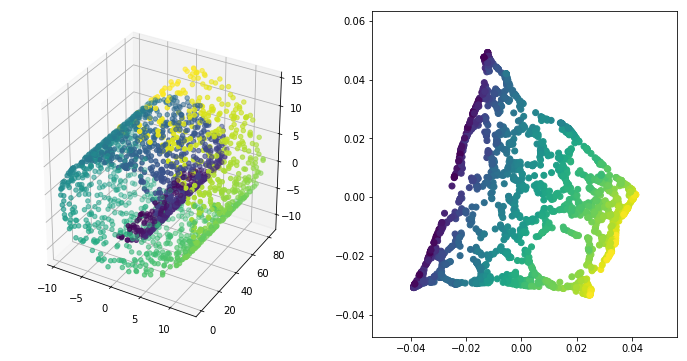

In [120]:
X, Y = make_swiss_roll(n_samples = 2000)
X_ndim = LE(X, n_neighbors = 5, t = 10)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c = Y)

ax2 = fig.add_subplot(122)
ax2.scatter(X_ndim[:, 0], X_ndim[:, 1], c = Y)
plt.show()

In [64]:
import numpy as np
 
def cosine_similarity(x,y):
    num = x.dot(y.T)
    denom = np.linalg.norm(x) * np.linalg.norm(y)
    return num / denom

# cosine_similarity(data[0],data[1])

In [111]:
tmp = new_dim_ans
# for i in range(len(proj)-1):
avg_train = np.zeros((tmp.shape[1],tmp.shape[2]))
avg_test = np.zeros((tmp.shape[1],tmp.shape[2]))
avg2 = 0.0
num = 3
for i in range(num):
    avg_train += abs(tmp[i,:,:]*255) / (num*1.0)
    avg_test  += abs(tmp[i+5,:,:]) / (num*1.0)
#     print(tmp_cos)
#     avg += tmp_cos
col = tmp.shape[1]
sss = []
print(col)
for i in range(col):
    cs = abs(cos_sim(abs(avg_train[i]),abs(tmp[4,i]*255)))
#     print(cs)
    sss.append(cs)
    avg2 += cs
    
# print(cosine_similarity(tmp[0],tmp[1]))
# avg2 = cosine_similarity(tmp[0][1],tmp[2][1])
print('avg',avg2/col)

112
avg 0.6919806712676516


In [ ]:
# coding:utf-8

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits,load_iris
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import KernelPCA
from sklearn import manifold
from scipy.spatial.distance import pdist, squareform

data = data[0]
print(data.shape)
# Y = load_iris().target
data_1 = KPCA(data, kernel=rbf_kpca)

sklearn_kpca = KernelPCA(n_components=2, kernel="rbf", gamma=15)
data_2 = sklearn_kpca.fit_transform(data)

plt.figure(figsize=(8,4))
plt.subplot(141)
plt.title("my_KPCA")
plt.scatter(data_1[:, 0], data_1[:, 1])

plt.subplot(142)
plt.title("sklearn_KPCA")
plt.scatter(data_2[:, 0], data_2[:, 1])
plt.show()

plt.title("LE")
# X = load_digits().data
# y = load_digits().target
dist = cal_pairwise_dist(data)
max_dist = np.max(dist)
print("max_dist", max_dist)
X_ndim = LE(data, n_neighbors = 2, t = max_dist*0.1)
plt.scatter(X_ndim[:, 0], X_ndim[:, 1])
plt.show()

In [ ]:
# -*- coding: utf-8 -*-
# !/usr/bin/env python
# @Time    : 2018/11/17 14:52
# @Author  : xhh
# @Desc    : 余弦相似度计算
# @File    : difference_image_consin.py
# @Software: PyCharm
from PIL import Image
from numpy import average, dot, linalg
 

def image_similarity_vectors_via_numpy(image1, image2):
#     image1 = get_thum(image1)
#     image2 = get_thum(image2)
    images = [image1, image2]
    vectors = []
    norms = []
    for image in images:
        vector = []
        for pixel_tuple in image:
            vector.append(average(pixel_tuple))
        vectors.append(vector)
        # linalg=linear（线性）+algebra（代数），norm则表示范数
        # 求图片的范数？？
        norms.append(linalg.norm(vector, 2))
    a, b = vectors
    a_norm, b_norm = norms
    # dot返回的是点积，对二维数组（矩阵）进行计算
    res = dot(a / a_norm, b / b_norm)
    return res
 
# image1 = Image.open('../dataset/100002.png')
# image2 = Image.open('../dataset/100001.png')
cosin = image_similarity_vectors_via_numpy(new_dim_ans[2], new_dim_ans[4])
print('图片余弦相似度',cosin)

In [ ]:
new_dim_ans[0]

In [9]:
def cos_sim(vector_a, vector_b):
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    sim = num / denom
    return sim
cos_sim(np.array([1,2,3]),np.array([1,2,5]))

0.9759000729485332